# Using Deep Learning for Sentence Classification

## Overview

Sentence-to-sentence Convolutional Neural Network for text classification: binary clasifier (predicting ReTweet)


#### Approach

- Use Twitter data, strip "RT" and predict whether this is a ReTweet (binary classification)  
- Split this data set into two sets - one for training our DL model, and one for evaluation  
- Use Keras to create a Convolutional Neural Network (CNN) with multiple layers. We will train this model on both CPU and GPU environments and compare runtimes  
- Evaluate and test the model on the test set and look at a few individual tweets examples  

#### Model performance (from papers):

- "CNN-rand" and "CNN-non-static" gets to 88-90%  
- "CNN-static" - 85% after 2-5 epochs with following settings:
    - embedding_dim = 50 filter_sizes = (3, 8) num_filters = 10 dropout_prob = (0.5, 0.8) hidden_dims = 50


### Running notebook on Midway CPUs / GPUs: 
Tutorial from Igor Yakushin: https://git.rcc.uchicago.edu/ivy2/MSCA_DL_example_1

1. If you are not on UChicago network, connect to VPN
2. Open PyTTY (Windows) or terminal (Mac) and SSH to midway2.rcc.uchicago.edu
3. Reserve a node for your exclusive usage
    - For CPUs: sinteractive -p broadwl --exclusive --time=05:00:00
    - For GPUs: sinteractive -p mscagpu --gres=gpu:1 --time=05:00:00 -A mscagpu  
    or
    - For GPUs: sinteractive -p mscagpu --exclusive --time=05:00:00 -A mscagpu    
4. cd into your Jupyter directory (for me cd "Jupyter Notebooks")
5. Obtain IP address: ifconfig eno1 | grep inet
6. Load modules:
    - For CPUs: module load Anaconda3/5.0.1
    - For GPUs: module load horovod
7. Get IP Address:
    - h=`hostname -i`
8. Launch notebook server: KERAS_BACKEND=tensorflow jupyter notebook --ip=$h --no-browser
9. Wait for the URL to paste into your browser:

# A Convolution Neural Network (CNN) for Sentence Classification
We borrow heavily from original work based on Yoon Kim's paper published in 2014 applying CNN models to text classification

Ref:
"Convolutional Neural Networks for Sentence Classification" by Yoon Kim

http://arxiv.org/pdf/1408.5882v2.pdf

This notebook uses Keras to replicate aspects of the above paper, and is using the following two references:

Work by Alexander Rakhlin:

https://github.com/alexander-rakhlin/CNN-for-Sentence-Classification-in-Keras

and work by Francois Chollet:

https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html

## High Level Overview of the Deep Learning Network Architecture

The following diagram shows a CNN architecture. We will create something very similar. 
We will create a convolution layer (applying filters to an input space), we will sub sample down to a much reduced feature space. We will further reduce the feature space before outputting a single classification.


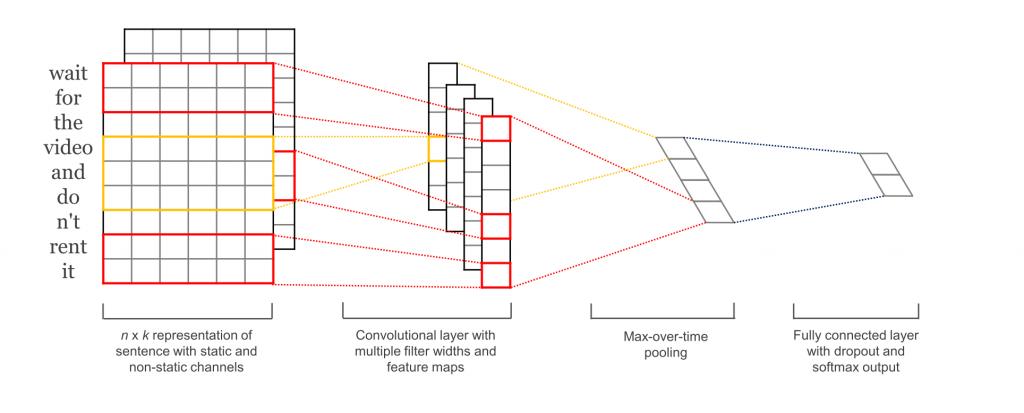
http://www.wildml.com/wp-content/uploads/2015/11/Screen-Shot-2015-11-06-at-8.03.47-AM-1024x413.png

The network will be presented with the first 200 words of a Tweet, the above network has 9 'words' as input. A single Tweet's words are presented at once. Text is considered 1 dimensional, while a static image is 2 dimensional.

- Training proceeds by looking at batches of tweets. The label of the tweet (class or sentiment) is the output and our loss function is a simple compare of the model prediction (0-1) against actual (0 or 1).

- The initial step is to convert each word to its vector space representation, here we will use GloVE's pre-trained embeddings (100d model) - each word is mapped into a 100 dimensional space. This architechture can also leverage custom-trained model, Google's Word2vec or Facebok's Fasttext.  We can also initialize our embeddings randomly (instead of using pretrained model).  

- The convolution part of our network is a 1 dimensional slide thru the input embeddings, the window of this slide can be any number of the words (in sequence). We will start by creating a single convolution layer, note that research and other investigations show multiple convolution layers appear to work better.

- Our single convolution will have a window of size 3 (the filter will span 3 words) and it will slide one "step" at a time thru a tweet (200 words). 

- In Deep Learning terminology, the filter is the 'mask' that slides. We will create 10 random filter shapes (fitting the word embedding dimension - here 100, and spanning 3 words).

- We will create a single convolutional layer consisting of 10 filters each of shape (3,100).

- The result of the convolutions are vectors. We then take a very simple global "MaxPooling" which simply means we take the maximum value from this vector and produce a single number "per filter".

- Because we have 10 filters we will have 10 numbers representing the strongest response of each filter.

- We feed these 10 through to a densely connected layer, meaning all 10 units in our previous layer are connected to all 5 units in this layer.

- Note we add here a "drop out" function. This takes effect during training, and ignores a certain(stochastically chosen) x% of the weights. We choose x=20% meaning 1/5 of the weights will be held constant during training. This forces the network to generalise and not overfit the training data.

- This layer then feeds into an output layer of one unit, again densely connected. This final unit represents our 0-1 classification.

- Further model performance can be improved by hyper parameter tuning.

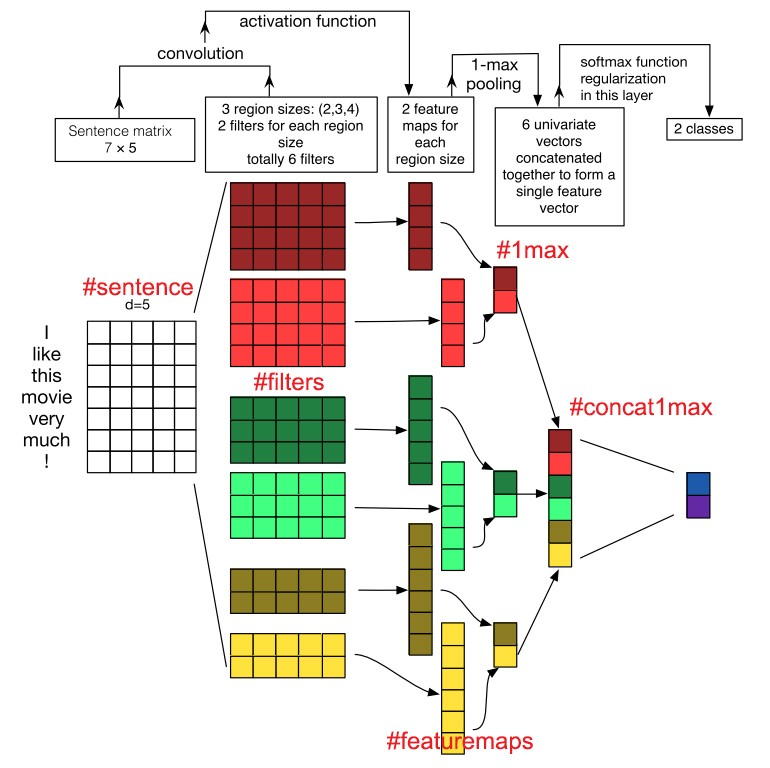

In [1]:
from IPython.display import Image
Image(filename='/project/msca/kadochnikov/images/cnn_picture.jpg') 

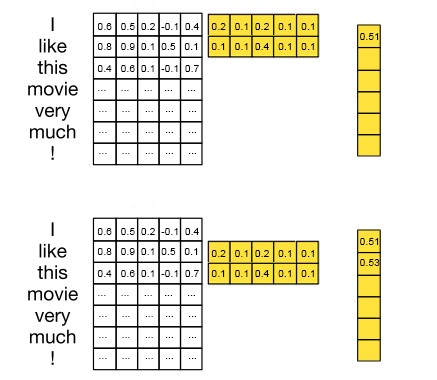

In [2]:
Image(filename='/project/msca/kadochnikov/images/action_of_filter_on_words.jpg') 

In [3]:
import numpy as np
import pandas as pd
import os, re, time
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [4]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [5]:
from multiprocessing import cpu_count
print(cpu_count())

28


In [6]:
#Verify we got CPU + GPU or only CPU
import tensorflow as tf
tf.Session().list_devices()

[_DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 268435456),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:0, GPU, 15858476647),
 _DeviceAttributes(/job:localhost/replica:0/task:0/device:GPU:1, GPU, 15858476647)]

In [7]:
import keras

from keras.wrappers.scikit_learn import KerasClassifier
from keras.preprocessing.text import Tokenizer, text_to_word_sequence
from keras.preprocessing import sequence
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, GRU, Convolution1D, Flatten, LeakyReLU
from keras.layers import Bidirectional, GlobalMaxPool1D, GlobalAveragePooling1D, MaxPooling1D, GlobalMaxPooling1D
from keras.layers.merge import Concatenate

from keras.models import Model, Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.utils import np_utils
from keras import callbacks
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.datasets import imdb

#from keras.preprocessing import sequence

print(keras.__version__)

Using TensorFlow backend.


2.2.4


### Load Data

In [8]:
tweets = pd.read_pickle("/project/msca/kadochnikov/text/tweets/tweets.pkl")

In [9]:
#categories = ['game', 'city']
categories = ['university', 'other']
#tweets_raw = tweets_raw[tweets_raw['tweet_class'].isin(categories)].reset_index(drop=True)

tweets.head(5)

,id,lang,created_at,screen_name,location,retweet_count,retweet,text_no_rt,tweet_class,text_clean
0,8.869222e+17,en,Mon Jul 17 12:15:01 +0000 2017,ABBRobotics,None,0.0,,Industrial robotics powerhouse #ABB will be de...,other,Industrial robotics powerhouse #ABB will be de...
1,8.869222e+17,en,Mon Jul 17 12:15:01 +0000 2017,pamityang2an,di hati pendengarnya.,0.0,,English Letters Department of Sanata Dharma Un...,university,English Letters Department of Sanata Dharma Un...
2,8.869222e+17,en,Mon Jul 17 12:15:01 +0000 2017,kyamichami1989,None,0.0,,Mouse Rabbit coffee☕️\n#Konkuk University \n#N...,university,Mouse Rabbit coffee☕️ #Konkuk University #Neu...
3,8.869222e+17,en,Mon Jul 17 12:15:02 +0000 2017,MyEyesBabyEyes,Connecticut,0.0,,https://t.co/Ijz5lX62TQ: Queen + Adam Lambert ...,other,https://t.co/Ijz5lX62TQ: Queen + Adam Lambert ...
4,8.869222e+17,en,Mon Jul 17 12:15:02 +0000 2017,Lajaune_,Tampa,0.0,RT,@teosacarfotos: You really are a Chicago nigga...,other,RT @teosacarfotos: You really are a Chicago ni...


#### Clean special charachters, otherwise tokenizer will err-out

In [10]:
tweets['text'] = tweets['text_no_rt'].map(lambda x: re.sub('[^a-zA-Z0-9 @ . , : - _]', ' ', str(x)))

In [11]:
tweets[['text', 'text_no_rt']].head(5)

,text,text_no_rt
0,Industrial robotics powerhouse ABB will be de...,Industrial robotics powerhouse #ABB will be de...
1,English Letters Department of Sanata Dharma Un...,English Letters Department of Sanata Dharma Un...
2,Mouse Rabbit coffee Konkuk University Neu...,Mouse Rabbit coffee☕️\n#Konkuk University \n#N...
3,https: t.co Ijz5lX62TQ: Queen Adam Lambert ...,https://t.co/Ijz5lX62TQ: Queen + Adam Lambert ...
4,@teosacarfotos: You really are a Chicago nigga...,@teosacarfotos: You really are a Chicago nigga...


#### Set text variable and target variable

In [12]:
#Column with clean text
textVar = tweets[["text"]]

#Target columns (sentiment, class, etc.)
targetVar = tweets["retweet"]

#### Verify target variable distribution

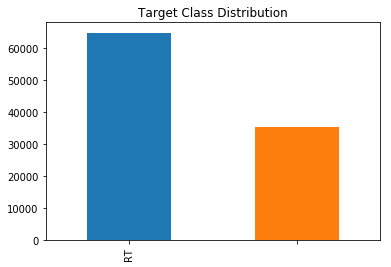

In [13]:
countClasses = pd.value_counts(targetVar.values, sort=True)
countClasses.plot.bar(legend=None, title="Target Class Distribution")
plt.show()

### Balance target variable class

In [14]:
g = tweets.groupby('retweet')
tweetsNew = pd.DataFrame(g.apply(lambda x: x.sample(g.size().min()).reset_index(drop=True)))
tweetsNew.reset_index(level=0, drop=True, inplace=True)

In [15]:
tweetsRaw = tweets
del tweets
tweets = tweetsNew
del tweetsNew

print("Original Dataframe:", tweetsRaw.shape)
print("Balanced Dataframe:", tweets.shape)

Original Dataframe: (100000, 11)
Balanced Dataframe: (70480, 11)


#### Reset variables and verify rebalancing worked

In [16]:
#Column with clean text
textVar = tweets[["text"]]

#Target columns (sentiment, class, etc.)
targetVar = tweets["retweet"]

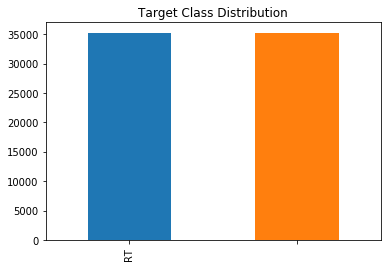

In [17]:
countClasses = pd.value_counts(targetVar.values, sort=True)
countClasses.plot.bar(legend=None, title="Target Class Distribution")
plt.show()

#### Split data into train and test

In [18]:
X = textVar

encoder = preprocessing.LabelEncoder()
encoder.fit(targetVar)
Y = encoder.transform(targetVar)

X_train, X_test, y_train, y_test = \
train_test_split(X, Y, stratify=targetVar, test_size = 0.33, random_state = 1010)

print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(47221, 1) (47221,)
(23259, 1) (23259,)


### Parameters
Here we specify the parameters of our data and model space to be used through out the notebook.

In [19]:
# make our experiments repeatable
np.random.seed(0)

# Model Hyperparameters
embedding_dim = 100
num_filters = 10
filter_size = 3

# Here we specify the number of units of our hidden layer
hidden_dims = 5

# Training parameters. Here we specify the training of the net will use 64 examples for each backprop iteration
batch_size = 64
# We will go thru the entire data set 20 times
num_epochs = 20

# Prepossessing parameters
# We will only input the first 200 words of every tweet (and pad out with nulls if a tweet is <200 words
# We will also build our model using the most frequent 5000 words in our tweet 'dictionary'
sequence_length = 200
max_words = 5000

#Specify the number of classes to predict (1 for binary classification or count unique values for multilabel classification)
num_classes = 1
#num_classes = target.nunique()

#### Tokenize the data and pad sequences

In [20]:
max_features = 200000

tokenizer = Tokenizer(num_words=max_features, char_level=False)
#tokenizer.fit_on_texts(X_train['text'].values)
#Fit tokenizer to entire data (not just Train)
tokenizer.fit_on_texts(tweets["text"].values)


input_vocab_size = len(tokenizer.word_index) + 1
vocabulary = tokenizer.word_index
vocabulary_inv = dict((v, k) for k, v in vocabulary.items())
vocabulary_inv[0] = "<PAD/>"


x_train = tokenizer.texts_to_sequences(X_train['text'].values)
x_train = sequence.pad_sequences(x_train, maxlen=sequence_length, padding="post",
                                 truncating="post")

x_test = tokenizer.texts_to_sequences(X_test['text'].values)
x_test = sequence.pad_sequences(x_test, maxlen=sequence_length, padding="post",
                                 truncating="post")

#### Tokenized and padded input is a Numpy Array

In [21]:
print(x_train)

[[30371  5711  5259 ...     0     0     0]
 [  450  1286    19 ...     0     0     0]
 [  352   276  1564 ...     0     0     0]
 ...
 [ 4052   343    17 ...     0     0     0]
 [19606    12   108 ...     0     0     0]
 [  134  1138  2596 ...     0     0     0]]


In [22]:
print(y_train)

[1 0 0 ... 0 1 1]


### View our Data

In [23]:
# Check how many columns we have, make sure we have our sequence length set correctly

if sequence_length != x_test.shape[1]:
    print("Adjusting sequence length for actual size")
    sequence_length = x_test.shape[1]

print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)
print("Vocabulary Size: {:d}".format(len(vocabulary_inv)))

x_train shape: (47221, 200)
x_test shape: (23259, 200)
Vocabulary Size: 101697


In [24]:
print("y train shape is %s" % (y_train.shape,))
print("y test shape is %s" % (y_test.shape,))

y train shape is (47221,)
y test shape is (23259,)


In [25]:
# Investigate the vocab here - careful - will print 88k rows

#vocabulary.items()

### Show a Tweet and its Class

In [26]:
# Create a function so we can re-use later

def print_review(features, y, n):
    """
    """
    for x in np.nditer(features[n,]):
        w = vocabulary_inv[np.asscalar(x)]
        if (w!='<PAD/>'):
            print(w +" ", end='')
    print("\n\nWith classification of %s" % (y[n],))

# Randomly pick a tweet number
print_review(x_train, y_train, 755)


ptsrehab congratulations to dr heath he received his doctor of physical therapy degree from the college of nursing and allied heal 

With classification of 1


### Load the pretrained vector space model (glove.twitter.27B.100d.txt)
This contains 1.2M word vectors.

GloVe embedding data can be found at:

http://nlp.stanford.edu/data/glove.6B.zip

(source page: http://nlp.stanford.edu/projects/glove/)

Here we will use data trained on Twitter (2B tweets, 27B tokens, 1.2M vocab)

For non-Twitter data,
Gigaword -  is a comprehensive archive of newswire text data that has been acquired over several years by the LDC at the University of Pennsylvania. The fifth edition includes all of the contents in English Gigaword Fourth Edition (LDC2009T13) plus new data covering the 24-month period of January 2009 through December 2010.

The seven distinct international sources of English newswire included in this edition are the following:

    Agence France-Presse, English Service (afp_eng)
    Associated Press Worldstream, English Service (apw_eng)
    Central News Agency of Taiwan, English Service (cna_eng)
    Los Angeles Times/Washington Post Newswire Service (ltw_eng)
    Washington Post/Bloomberg Newswire Service (wpb_eng)
    New York Times Newswire Service (nyt_eng)
    Xinhua News Agency, English Service (xin_eng)


In [27]:
# Verify our pre downloaded glove model is available...

#! wget -P /project/msca/kadochnikov/wordvec http://nlp.stanford.edu/data/glove.6B.zip
# !wget -P /project/msca/kadochnikov/wordvec http://nlp.stanford.edu/data/glove.twitter.27B.zip
!ls /project/msca/kadochnikov/wordvec/glove*

/project/msca/kadochnikov/wordvec/glove.6B.100d.txt
/project/msca/kadochnikov/wordvec/glove.6B.200d.txt
/project/msca/kadochnikov/wordvec/glove.6B.300d.txt
/project/msca/kadochnikov/wordvec/glove.6B.50d.txt
/project/msca/kadochnikov/wordvec/glove.6B.zip
/project/msca/kadochnikov/wordvec/glove.twitter.27B.100d.txt
/project/msca/kadochnikov/wordvec/glove.twitter.27B.200d.txt
/project/msca/kadochnikov/wordvec/glove.twitter.27B.25d.txt
/project/msca/kadochnikov/wordvec/glove.twitter.27B.50d.txt
/project/msca/kadochnikov/wordvec/glove.twitter.27B.zip


In [28]:
embeddings_index = {}

glove_dir = '/project/msca/kadochnikov/wordvec/'
f = open(os.path.join(glove_dir, 'glove.twitter.27B.100d.txt'), encoding="utf8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 1193514 word vectors.


The embeddings_index is a dictionary.

Key   => the word

Value => a 100 dimenension vector

For example:

In [29]:
embeddings_index['university']

array([-0.14204  ,  0.087893 ,  0.68497  ,  0.50281  , -0.1521   ,
       -0.364    ,  0.85268  ,  0.94866  , -0.706    , -0.45722  ,
       -0.36344  ,  0.68732  , -2.9483   ,  0.30908  ,  0.99038  ,
       -0.89146  , -0.30336  , -0.33155  ,  0.0094114, -1.0116   ,
        0.54782  , -0.54875  , -0.75414  ,  0.13272  , -0.82172  ,
        0.38451  , -0.51839  , -0.62293  ,  0.4098   , -0.34612  ,
       -0.12937  , -0.030638 , -0.5716   , -0.24597  ,  1.1056   ,
       -0.16862  , -0.15026  ,  1.391    ,  0.44723  , -0.13003  ,
       -0.097924 , -0.19129  , -0.29996  , -0.8154   ,  0.34281  ,
        0.40918  ,  0.077292 ,  0.37937  , -0.093287 , -1.1233   ,
        0.38256  , -0.45083  , -0.47194  ,  0.79936  , -0.53691  ,
       -0.56037  ,  0.42059  , -1.2564   , -0.88775  ,  0.25853  ,
        0.53916  ,  0.74312  , -0.35246  , -0.87817  , -0.5338   ,
       -0.084437 , -0.74957  , -0.57747  ,  0.49657  , -1.0336   ,
        0.063801 , -0.39771  ,  0.81657  ,  0.16483  , -0.0998

#### Create the Embedding Matrix

Here we initialise a zero matrix (2d numpy array) of size  \[vocab x 100]

and then populate it with the GloVe word vectors for each word in our vocab.



In [30]:
# Create our embedding matrix - this will allow us to go from a word in our tweets to its vector space representation

embedding_matrix = np.zeros((len(vocabulary) + 1, embedding_dim))
for word, i in vocabulary.items():
    embedding_vector = embeddings_index.get(word)
    if (word=='university'):
        print("word is %s at index %d " % (word, i))
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

word is university at index 4 


In [31]:
print("Our vocab has word count %d" % (len(vocabulary)+1))
print("Matrix shape is ", embedding_matrix.shape)
print("Example row is ", embedding_matrix[100])

Our vocab has word count 101697
Matrix shape is  (101697, 100)
Example row is  [ 1.07299998e-01  3.60579997e-01  1.11350000e-01 -1.63880009e-02
  2.44619995e-01  3.32480013e-01  1.49660006e-01  2.08669994e-03
 -4.82470006e-01 -7.79829979e-01 -2.48170003e-01 -1.36230007e-01
 -4.87419987e+00 -1.26399994e-01  1.97180003e-01 -2.34380007e-01
  3.17310005e-01 -5.37660003e-01 -3.36360008e-01  3.22439998e-01
  3.48379999e-01  3.23920012e-01  1.29829999e-02 -4.38419998e-01
 -3.55469994e-02  4.07940000e-01 -2.90369987e-01  2.69389987e-01
  2.89620012e-01 -6.86950028e-01 -6.20530009e-01  1.01829998e-01
 -5.00909984e-01  2.56669998e-01  5.34749985e-01  5.68650007e-01
  7.89830029e-01 -3.87519985e-01 -4.74269986e-01 -4.48890001e-01
 -3.55830014e-01 -1.20180003e-01 -2.37199999e-02  3.83899987e-01
  4.29969996e-01  3.42729986e-01  2.44469997e-02 -1.26690000e-01
  2.90010005e-01 -1.19470004e-02 -6.89179972e-02 -4.32480007e-01
 -6.03370011e-01 -3.21049988e-01  3.75499994e-01  3.68000001e-01
  1.6839000

In [32]:
#embedding_matrix[0:10,]
type(vocabulary.items())

dict_items

## Create the Network Architecture

We will create a CNN network.

Input - single 100 word document, each word converted to its vector space embedding.

Convolve - step thru the sequence of word embeddings and transform using a filter spanning 3 words.
We will create 10 filters for each span, each filter will be have shape (3,100) and will "slide down" the sequence of words.

The result of the convolution step will be another network layer - essentially the output max pooled for all filters. This layer then feeds a reduced layer (less neurons). Then finally to the single neuron "output".

Output - single "neuron" to output 0 for Negative and 1 for Positive.


### Prepare The Input Layer

First we need to convert our 100 words to their 100d embeddings, 

To do this we create our input to the model - in Keras this will be an "Embedding" layer.



In [33]:
# Use the pre trained GloVe model for our embedding layer
embedding_glove = Embedding(len(vocabulary) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=sequence_length,
                            trainable=False)

### Create the CNN Neural Network Structure
Here we create layer by layer the Deep Neural Network.




In [34]:
def cnn_create(embedding):
    """
    Create basic cnn structure
    embedding: keras Embedding
    return: compiled keras model
    """
    model = Sequential()

    model.add(embedding)

    model.add(Convolution1D(filters=10,
                             kernel_size=3,
                             padding="valid",
                             activation="relu",
                             strides=1))

    model.add(GlobalMaxPooling1D())

    # We add a dense layer (fully connected) to the previous layer with a 20% dropout (ignore 20% of units during weight updates)
    hidden_dims = 5
    model.add(Dense(hidden_dims))
    model.add(Dropout(0.2))
    model.add(Activation('relu'))

    # We project onto a single unit output layer, and squash it with a sigmoid:
    model.add(Dense(num_classes))
    model.add(Activation('sigmoid')) #use softmax for multilabel
    return(model)


In [35]:
glove_model = cnn_create(embedding_glove)
glove_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [36]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [37]:
glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          10169700  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 198, 10)           3010      
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 10)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
_________________________________________________________________
dropout_1 (Dropout)          (None, 5)                 0         
_________________________________________________________________
activation_1 (Activation)    (None, 5)                 0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6         
__________

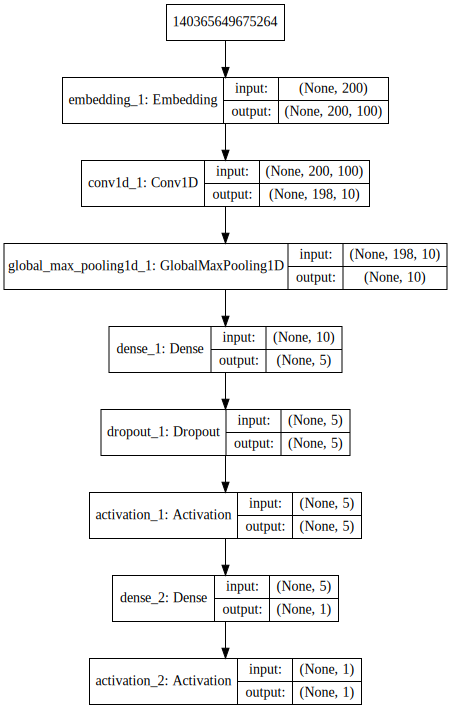

In [38]:
SVG(model_to_dot(glove_model, show_shapes=True).create(prog='dot', format='svg'))

### Train the CNN Model
On DSXL GPU's this takes ~ 40 seconds

With GPU on local P50 - ~4 minutes.

Without GPU and local CPU only - this took X minutes.

In [39]:
filepath="/project/msca/kadochnikov/dl_models/cnn_glove_weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                             verbose=1, save_best_only=True, mode='max') #only save model if it improves the accuracy
callbacks_list = [checkpoint]

t1 = time.time()
glove_history = glove_model.fit(x_train, y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_data=(x_test, y_test),
                    callbacks = callbacks_list,
                    verbose=2)
t2 = time.time()
print("CNN Glove model train time = %d seconds" %(t2-t1))

Train on 47221 samples, validate on 23259 samples
Epoch 1/20
 - 10s - loss: 0.6060 - acc: 0.6889 - val_loss: 0.5142 - val_acc: 0.8059

Epoch 00001: val_acc improved from -inf to 0.80592, saving model to cnn_glove_weights_best
Epoch 2/20
 - 5s - loss: 0.4928 - acc: 0.7829 - val_loss: 0.4115 - val_acc: 0.8432

Epoch 00002: val_acc improved from 0.80592 to 0.84324, saving model to cnn_glove_weights_best
Epoch 3/20
 - 5s - loss: 0.4355 - acc: 0.8174 - val_loss: 0.3801 - val_acc: 0.8543

Epoch 00003: val_acc improved from 0.84324 to 0.85434, saving model to cnn_glove_weights_best
Epoch 4/20
 - 5s - loss: 0.4124 - acc: 0.8291 - val_loss: 0.3742 - val_acc: 0.8496

Epoch 00004: val_acc did not improve from 0.85434
Epoch 5/20
 - 5s - loss: 0.3978 - acc: 0.8378 - val_loss: 0.3559 - val_acc: 0.8585

Epoch 00005: val_acc improved from 0.85434 to 0.85851, saving model to cnn_glove_weights_best
Epoch 6/20
 - 5s - loss: 0.3822 - acc: 0.8458 - val_loss: 0.3471 - val_acc: 0.8642

Epoch 00006: val_acc i

In [40]:
glove_history.history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

In [41]:
def plot_train(history):
    """
    Plot the keras epoch results thru training
    """
    h = history.history
    #loss_values = history_dict['loss']
    #val_loss_values = history_dict['val_loss']
    #acc = history_dict['acc']
    #val_acc = history_dict['val_acc']
    
    #plt.plot(epochs, loss_values, 'bo', label='Training loss')
    #plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    epochs = range(1, len(h['acc']) + 1)
    plt.plot(epochs, h['acc'], 'go', label='Training acc')
    plt.plot(epochs, h['val_acc'], 'g', label='Validation acc')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

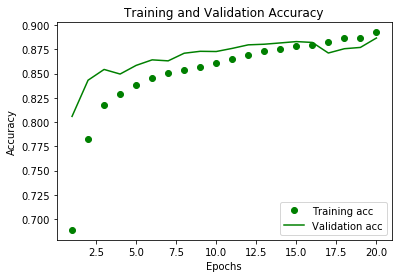

In [42]:
plot_train(glove_history)

### Does using GloVE help our model?

Lets test to see if using pre trained glove embeddings was actually useful.

We will create an embedding layer randomly intialised but trained as part of the deep learning fit process.

As before, we train over 20 epochs and keep the best model.

In [43]:
embedding_random = Embedding(len(vocabulary) + 1,
                             embedding_dim,
                             input_length=sequence_length,
                             trainable=True)
rand_model  = cnn_create(embedding_random)
rand_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])


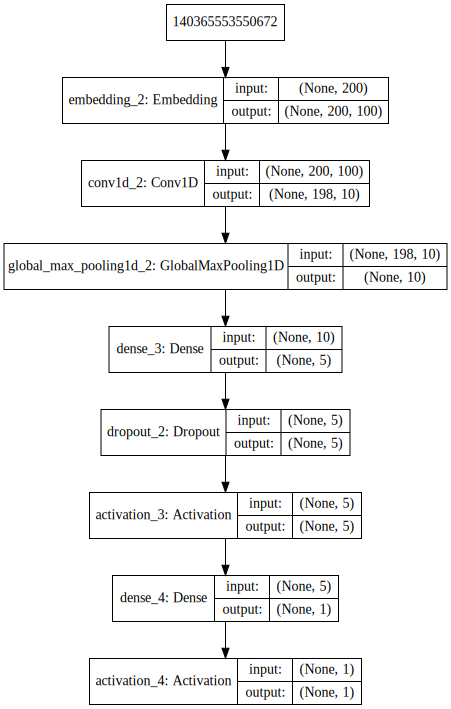

In [44]:
SVG(model_to_dot(rand_model, show_shapes=True).create(prog='dot', format='svg'))

In [45]:
filepath="/project/msca/kadochnikov/dl_models/cnn_rand_weights_best"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                             verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

t1 = time.time()
rand_history = rand_model.fit(x_train, y_train,
                    batch_size=batch_size, 
                    epochs=num_epochs,
                    validation_data=(x_test, y_test),
                    callbacks = callbacks_list,
                    verbose=2)
t2 = time.time()
print("CNN Random model train time = %d seconds" %(t2-t1))

Train on 47221 samples, validate on 23259 samples
Epoch 1/20
 - 9s - loss: 0.4874 - acc: 0.7396 - val_loss: 0.3293 - val_acc: 0.8673

Epoch 00001: val_acc improved from -inf to 0.86732, saving model to cnn_rand_weights_best
Epoch 2/20
 - 8s - loss: 0.2351 - acc: 0.9077 - val_loss: 0.3178 - val_acc: 0.8820

Epoch 00002: val_acc improved from 0.86732 to 0.88202, saving model to cnn_rand_weights_best
Epoch 3/20
 - 7s - loss: 0.0988 - acc: 0.9586 - val_loss: 0.3382 - val_acc: 0.8839

Epoch 00003: val_acc improved from 0.88202 to 0.88392, saving model to cnn_rand_weights_best
Epoch 4/20
 - 7s - loss: 0.0622 - acc: 0.9804 - val_loss: 0.3742 - val_acc: 0.8816

Epoch 00004: val_acc did not improve from 0.88392
Epoch 5/20
 - 7s - loss: 0.0455 - acc: 0.9851 - val_loss: 0.4439 - val_acc: 0.8139

Epoch 00005: val_acc did not improve from 0.88392
Epoch 6/20
 - 7s - loss: 0.0372 - acc: 0.9869 - val_loss: 0.4572 - val_acc: 0.8522

Epoch 00006: val_acc did not improve from 0.88392
Epoch 7/20
 - 7s - l

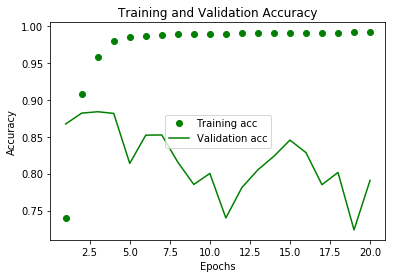

In [46]:
plot_train(rand_history)

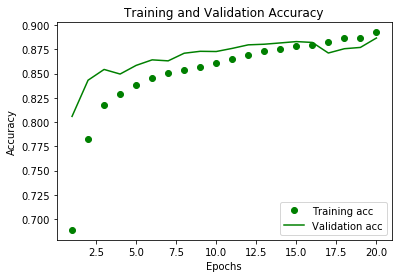

In [47]:
plot_train(glove_history)

### Explore the model

In [48]:
glove_history.model.get_config()

{'name': 'sequential_1',
 'layers': [{'class_name': 'Embedding',
   'config': {'name': 'embedding_1',
    'trainable': False,
    'batch_input_shape': (None, 200),
    'dtype': 'float32',
    'input_dim': 101697,
    'output_dim': 100,
    'embeddings_initializer': {'class_name': 'RandomUniform',
     'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}},
    'embeddings_regularizer': None,
    'activity_regularizer': None,
    'embeddings_constraint': None,
    'mask_zero': False,
    'input_length': 200}},
  {'class_name': 'Conv1D',
   'config': {'name': 'conv1d_1',
    'trainable': True,
    'filters': 10,
    'kernel_size': (3,),
    'strides': (1,),
    'padding': 'valid',
    'data_format': 'channels_last',
    'dilation_rate': (1,),
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'class_name': 'VarianceScaling',
     'config': {'scale': 1.0,
      'mode': 'fan_avg',
      'distribution': 'uniform',
      'seed': None}},
    'bias_initializer': {'c

In [49]:
# Evaluate the model on test set

# load weights for the 'best' model
glove_model.load_weights("cnn_glove_weights_best")
#score = glove_history.model.evaluate(x_test, y_test, batch_size=64)
score = glove_model.evaluate(x_test, y_test, batch_size=64)

#print(history.model.metrics_names)
print(score)

23259/23259 [==============================] - 1s 29us/step
[0.3147188140251317, 0.8867535147582262]


In [50]:
# Make a prediction on single tweet:
n = 100
print_review(x_test, y_test, n)
pred = glove_model.predict(x_test[n:n+1])
print("CNN Model Prediction is %f" % (pred[0]))


chicago ashland n of monterey body of gunshot victim on ground nbcsky5 live nbcchicago kyemartinnbc https t co zopip09kbl 

With classification of 0
CNN Model Prediction is 0.000011
